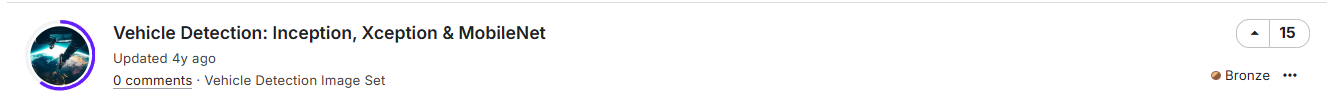

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

In [3]:
# Selecting Dataset Folder Paths
dir_ = Path('D:\code_study\ML_CODE\dataSets\Vehicle_Detection_Image_Set\data')
filepaths = list(dir_.glob(r'**/*.png'))
# Mapping the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Paths & labels femalee eyes
filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating...
df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)
df

,File,Label
0,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles
1,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles
2,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles
3,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles
4,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles
...,...,...
17755,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles
17756,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles
17757,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles
17758,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles


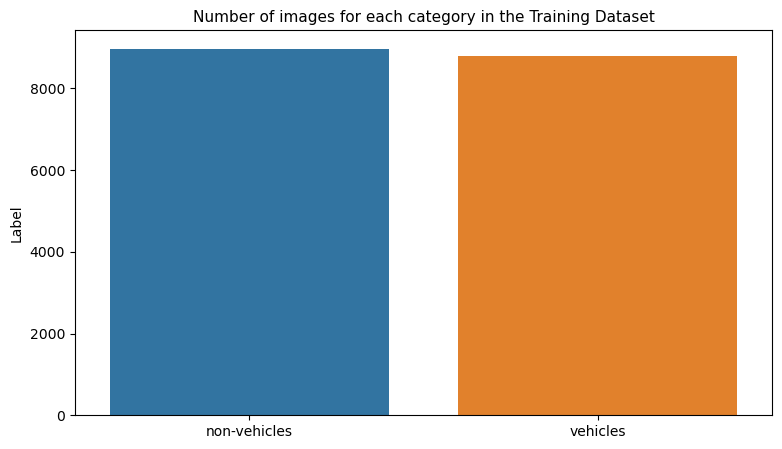

In [4]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

In [5]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'non-vehicles')

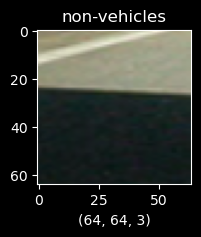

In [6]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'vehicles')

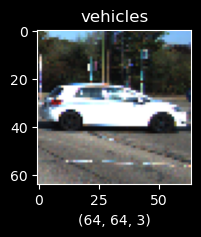

In [7]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][15])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][15])

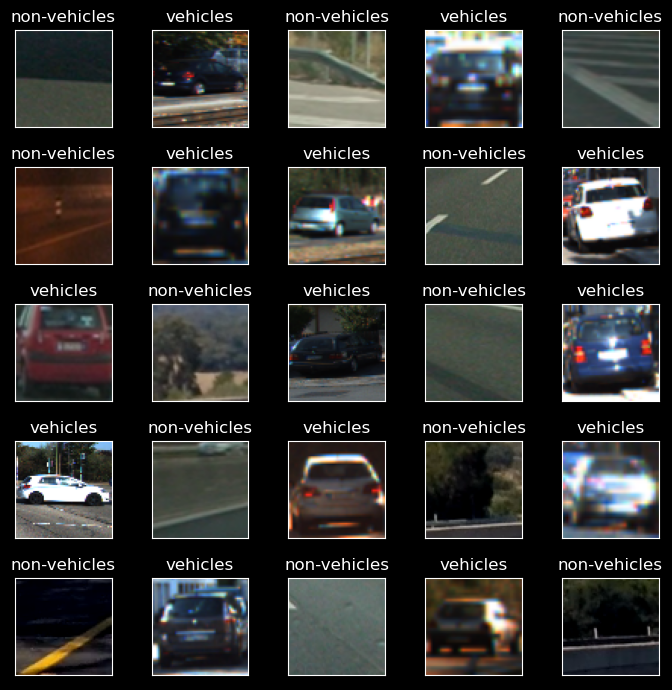

In [8]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

In [9]:
trainset_df, testset_df = train_test_split(df, train_size = 0.90, random_state = 42)

display(trainset_df.head())

testset_df.head()

,File,Label
5758,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles
11522,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles
3143,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles
8774,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles
9845,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles


,File,Label
15314,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles
11728,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,non-vehicles
10379,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles
6323,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles
5155,D:\code_study\ML_CODE\dataSets\Vehicle_Detecti...,vehicles


In [10]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [11]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 15984
Number of images with malee eyes: 8076
Number of images with femalee eyes: 7908

Test Dataset:
Number of images: 1776
Number of images with malee eyes: 892
Number of images with femalee eyes: 884



In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 14386 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1598 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 1776 validated image filenames belonging to 2 classes.
Data generators are ready!


In [14]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

In [15]:
CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

In [16]:
for layer in CNN_base_inc.layers:
    layer.trainable = False

In [17]:
x = layers.Flatten()(CNN_base_inc.output)

In [18]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)

CNN_inc = Model(CNN_base_inc.input, x)

In [19]:
# Compilation
CNN_inc.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

Epoch 1/25
450/450 [==============================] - 270s 587ms/step - loss: 0.2209 - accuracy: 0.9211 - val_loss: 0.0774 - val_accuracy: 0.9706
Epoch 2/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0802 - accuracy: 0.9730 - val_loss: 0.0683 - val_accuracy: 0.9781
Epoch 3/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0720 - accuracy: 0.9741 - val_loss: 0.0527 - val_accuracy: 0.9775
Epoch 4/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0716 - accuracy: 0.9734 - val_loss: 0.0609 - val_accuracy: 0.9800
Epoch 5/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0612 - accuracy: 0.9791 - val_loss: 0.0691 - val_accuracy: 0.9775
Epoch 6/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0588 - accuracy: 0.9804 - val_loss: 0.0525 - val_accuracy: 0.9837
Epoch 7/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0644 - accuracy: 0.9773 - val_loss: 0.0544 - val_accurac

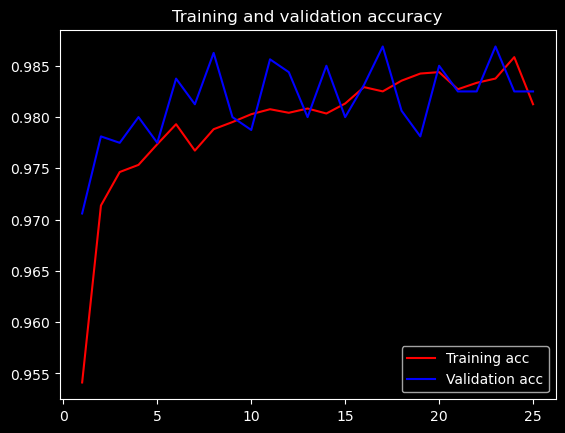

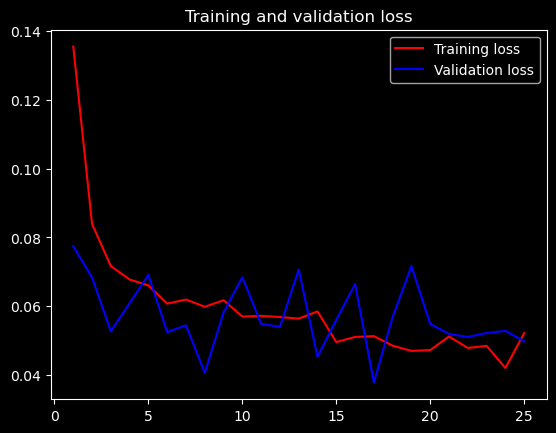

In [20]:
acc = CNN_inc_history.history['accuracy']
val_acc = CNN_inc_history.history['val_accuracy']
loss = CNN_inc_history.history['loss']
val_loss = CNN_inc_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [21]:
score_inc = CNN_inc.evaluate(test_set)
print("Test Loss:", score_inc[0])
print("Test Accuracy:", score_inc[1])

56/56 [==============================] - 27s 490ms/step - loss: 0.0330 - accuracy: 0.9893
Test Loss: 0.03300594910979271
Test Accuracy: 0.9893018007278442


In [22]:
y_pred_inc = CNN_inc.predict(test_set)
y_pred_inc = np.round(y_pred_inc)

recall_inc = recall_score(y_test, y_pred_inc)
precision_inc = precision_score(y_test, y_pred_inc)
f1_inc = f1_score(y_test, y_pred_inc)
roc_inc = roc_auc_score(y_test, y_pred_inc)

In [23]:
print(classification_report(y_test, y_pred_inc))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       892
           1       0.98      1.00      0.99       884

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



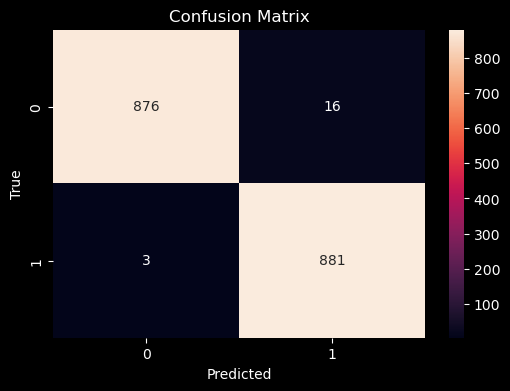

In [24]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_inc),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [25]:
CNN_base_xcep = Xception(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')
CNN_base_xcep.trainable = False

In [26]:
CNN_xcep = Sequential()
CNN_xcep.add(CNN_base_xcep)
CNN_xcep.add(GlobalAveragePooling2D())
CNN_xcep.add(Dense(128))
CNN_xcep.add(Dropout(0.1))
CNN_xcep.add(Dense(1, activation = 'sigmoid'))

CNN_xcep.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 21,123,881
Trainable params: 262,401
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#plot_model(CNN_xcep, show_layer_names = True , show_shapes = True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [28]:
# Compilation
CNN_xcep.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_xcep_history = CNN_xcep.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_xcep = end - start
print ('\nTraining and validation time: ', time_CNN_xcep)

Epoch 1/25
450/450 [==============================] - 20s 41ms/step - loss: 0.1887 - accuracy: 0.9393 - val_loss: 0.0692 - val_accuracy: 0.9775
Epoch 2/25
450/450 [==============================] - 17s 37ms/step - loss: 0.0691 - accuracy: 0.9805 - val_loss: 0.0389 - val_accuracy: 0.9900
Epoch 3/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0759 - accuracy: 0.9814 - val_loss: 0.0455 - val_accuracy: 0.9881
Epoch 4/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0569 - accuracy: 0.9864 - val_loss: 0.0587 - val_accuracy: 0.9844
Epoch 5/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0495 - accuracy: 0.9852 - val_loss: 0.0454 - val_accuracy: 0.9881
Epoch 6/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0375 - accuracy: 0.9901 - val_loss: 0.0423 - val_accuracy: 0.9875
Epoch 7/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0396 - accuracy: 0.9880 - val_loss: 0.0545 - val_accuracy:

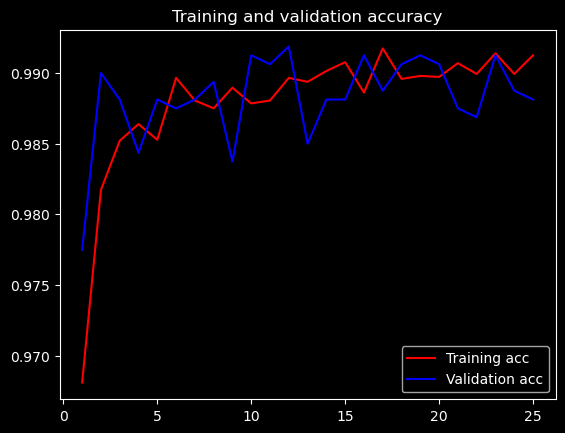

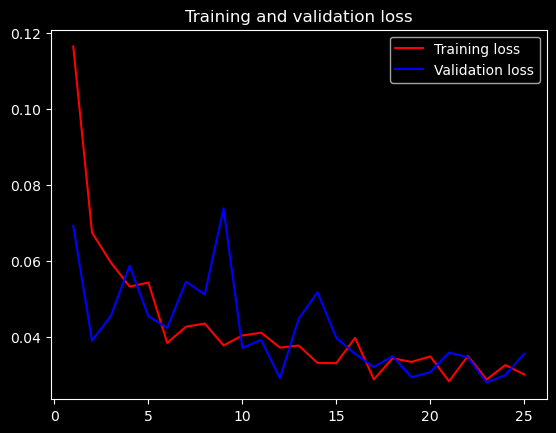

In [29]:
acc = CNN_xcep_history.history['accuracy']
val_acc = CNN_xcep_history.history['val_accuracy']
loss = CNN_xcep_history.history['loss']
val_loss = CNN_xcep_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [30]:
score_xcep = CNN_xcep.evaluate(test_set)
print("Test Loss:", score_xcep[0])
print("Test Accuracy:", score_xcep[1])

56/56 [==============================] - 1s 26ms/step - loss: 0.0352 - accuracy: 0.9876
Test Loss: 0.035157009959220886
Test Accuracy: 0.9876126050949097


In [31]:
y_pred_xcep = CNN_xcep.predict(test_set)
y_pred_xcep = np.round(y_pred_xcep)

recall_xcep = recall_score(y_test, y_pred_xcep)
precision_xcep = precision_score(y_test, y_pred_xcep)
f1_xcep = f1_score(y_test, y_pred_xcep)
roc_xcep = roc_auc_score(y_test, y_pred_xcep)

In [32]:
print(classification_report(y_test, y_pred_xcep))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       892
           1       0.99      0.98      0.99       884

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



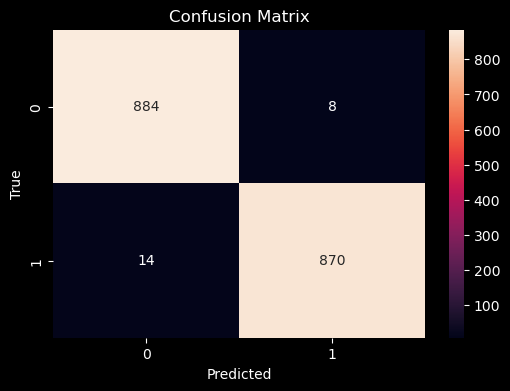

In [33]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_xcep),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [34]:
CNN_base_mobilenet = MobileNet(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

17227776/17225924 [==============================] - 107s 6us/step


In [35]:
for layer in CNN_base_mobilenet.layers:
    layer.trainable = False

In [36]:
CNN_mobilenet = Sequential()
CNN_mobilenet.add(BatchNormalization(input_shape = (75, 75, 3)))
CNN_mobilenet.add(CNN_base_mobilenet)
CNN_mobilenet.add(BatchNormalization())
CNN_mobilenet.add(GlobalAveragePooling2D())
CNN_mobilenet.add(Dropout(0.5))
CNN_mobilenet.add(Dense(1, activation = 'sigmoid'))

CNN_mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_98 (Batc (None, 75, 75, 3)         12        
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
batch_normalization_99 (Batc (None, 2, 2, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 3,233,997
Trainable params: 3,079
Non-trainable params: 3,230,918
________________________________________

In [37]:
# Compilation
CNN_mobilenet.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_mobilenet_history = CNN_mobilenet.fit(training_set, epochs = 25, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_mobilenet = end - start
print ('\nTraining and validation time: ', time_CNN_mobilenet)

Epoch 1/25
450/450 [==============================] - 18s 37ms/step - loss: 0.2525 - accuracy: 0.8924 - val_loss: 0.0513 - val_accuracy: 0.9844
Epoch 2/25
450/450 [==============================] - 23s 52ms/step - loss: 0.0741 - accuracy: 0.9733 - val_loss: 0.0448 - val_accuracy: 0.9875
Epoch 3/25
450/450 [==============================] - 16s 36ms/step - loss: 0.0687 - accuracy: 0.9738 - val_loss: 0.0326 - val_accuracy: 0.9887
Epoch 4/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0650 - accuracy: 0.9752 - val_loss: 0.0370 - val_accuracy: 0.9856
Epoch 5/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0616 - accuracy: 0.9776 - val_loss: 0.0333 - val_accuracy: 0.9875
Epoch 6/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0576 - accuracy: 0.9787 - val_loss: 0.0304 - val_accuracy: 0.9887
Epoch 7/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0657 - accuracy: 0.9760 - val_loss: 0.0273 - val_accuracy:

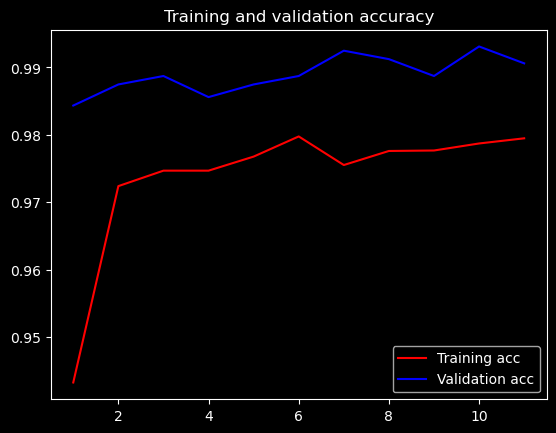

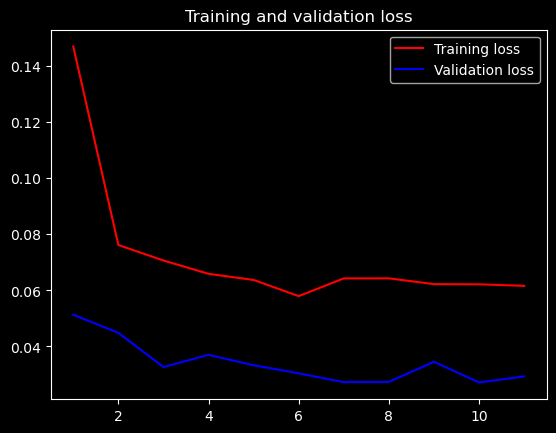

In [38]:
acc = CNN_mobilenet_history.history['accuracy']
val_acc = CNN_mobilenet_history.history['val_accuracy']
loss = CNN_mobilenet_history.history['loss']
val_loss = CNN_mobilenet_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [39]:
score_mn = CNN_mobilenet.evaluate(test_set)
print("Test Loss:", score_mn[0])
print("Test Accuracy:", score_mn[1])

56/56 [==============================] - 1s 14ms/step - loss: 0.0227 - accuracy: 0.9921
Test Loss: 0.022718770429491997
Test Accuracy: 0.9921171069145203


In [40]:
y_pred_mn = CNN_mobilenet.predict(test_set)
y_pred_mn = np.round(y_pred_mn)

recall_mn = recall_score(y_test, y_pred_mn)
precision_mn = precision_score(y_test, y_pred_mn)
f1_mn = f1_score(y_test, y_pred_mn)
roc_mn = roc_auc_score(y_test, y_pred_mn)

In [41]:
print(classification_report(y_test, y_pred_mn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.99      0.99      0.99       884

    accuracy                           0.99      1776
   macro avg       0.99      0.99      0.99      1776
weighted avg       0.99      0.99      0.99      1776



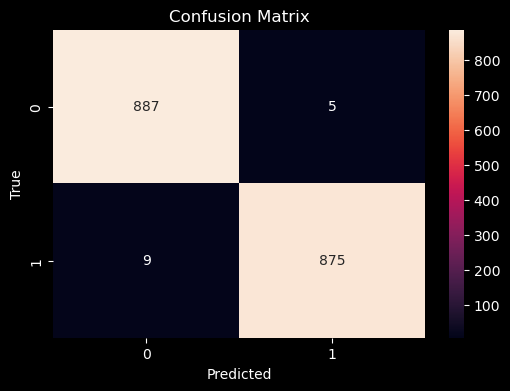

In [42]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_mn),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [43]:
models= [('Inception', time_CNN_inc, np.mean(CNN_inc_history.history['accuracy']), np.mean(CNN_inc_history.history['val_accuracy'])),
         ('Xception', time_CNN_xcep, np.mean(CNN_xcep_history.history['accuracy']), np.mean(CNN_xcep_history.history['val_accuracy'])),
         ('MobileNet', time_CNN_mobilenet, np.mean(CNN_mobilenet_history.history['accuracy']), np.mean(CNN_mobilenet_history.history['val_accuracy']))]

df_all_models = pd.DataFrame(models, columns = ['Model', 'Time', 'Training accuracy (%)', 'Validation Accuracy (%)'])

df_all_models

,Model,Time,Training accuracy (%),Validation Accuracy (%)
0,Inception,0 days 00:11:46.958736,0.979408,0.981552
1,Xception,0 days 00:06:47.477694,0.987963,0.988260
2,MobileNet,0 days 00:03:04.597277,0.973699,0.988963


In [44]:
models = [('Inception', score_inc[1], recall_inc, precision_inc, f1_inc, roc_inc),
          ('Xception', score_xcep[1], recall_xcep, precision_xcep, f1_xcep, roc_xcep),
          ('MobileNet', score_mn[1], recall_mn, precision_mn, f1_mn, roc_mn)]

df_all_models_testset = pd.DataFrame(models, columns = ['Model', 'Test accuracy (%)', 'Recall (%)', 'Precision (%)', 'F1 (%)', 'AUC'])

df_all_models_testset

,Model,Test accuracy (%),Recall (%),Precision (%),F1 (%),AUC
0,Inception,0.989302,0.996606,0.982163,0.989332,0.989335
1,Xception,0.987613,0.984163,0.990888,0.987514,0.987597
2,MobileNet,0.992117,0.989819,0.994318,0.992063,0.992107


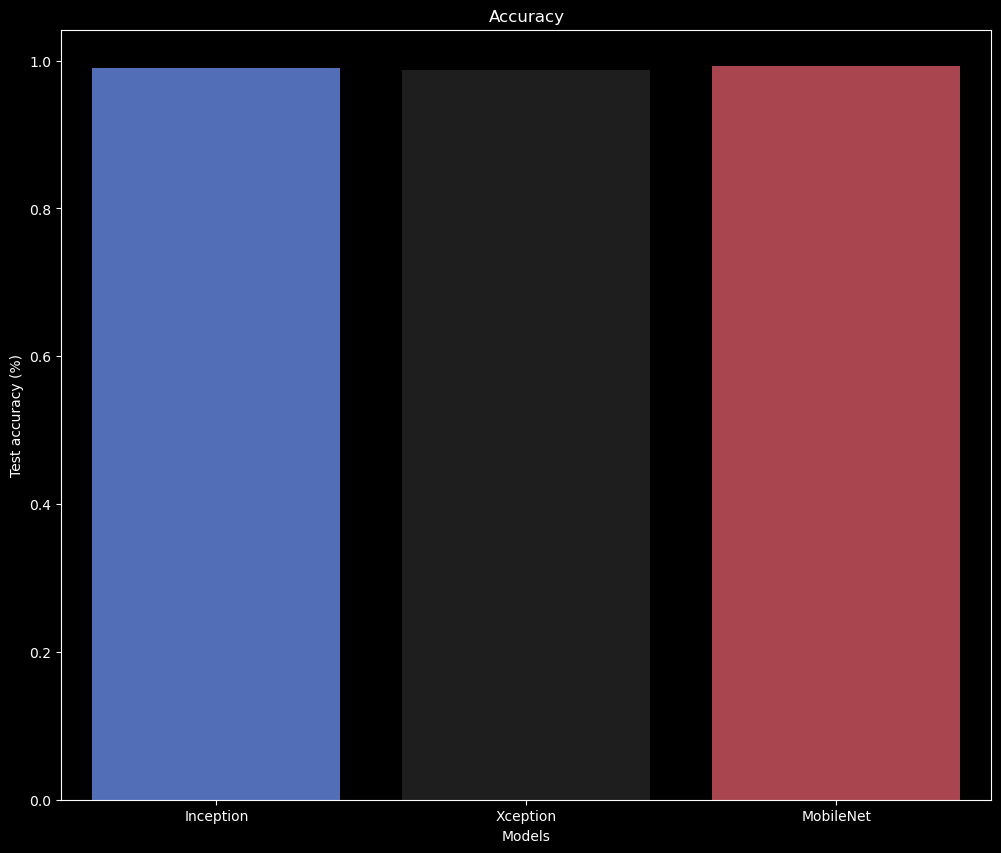

In [45]:
plt.subplots(figsize=(12, 10))
sns.barplot(y = df_all_models_testset['Test accuracy (%)'], x = df_all_models_testset['Model'], palette = 'icefire')
plt.xlabel("Models")
plt.title('Accuracy')
plt.show()

In [46]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

fpr_inc, tpr_inc, _ = roc_curve(y_test, y_pred_inc)
fpr_xcep, tpr_xcep, _ = roc_curve(y_test, y_pred_xcep)
fpr_mn, tpr_mn, _ = roc_curve(y_test, y_pred_mn)

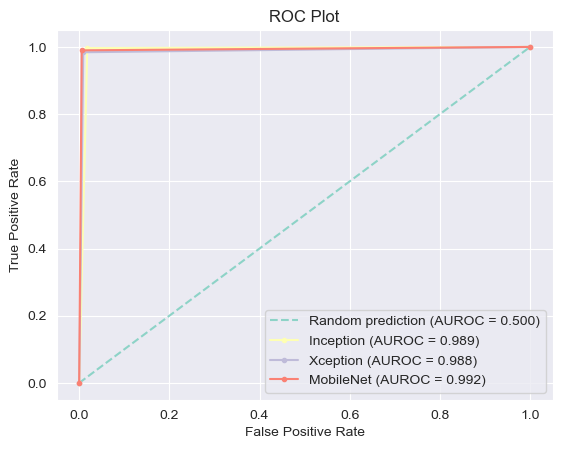

In [47]:
sns.set_style('darkgrid')

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)

plt.plot(fpr_inc, tpr_inc, marker='.', label='Inception (AUROC = %0.3f)' % roc_inc)
plt.plot(fpr_xcep, tpr_xcep, marker='.', label='Xception (AUROC = %0.3f)' % roc_xcep)
plt.plot(fpr_mn, tpr_mn, marker='.', label='MobileNet (AUROC = %0.3f)' % roc_mn)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

In [48]:
test_set.class_indices

{'non-vehicles': 0, 'vehicles': 1}

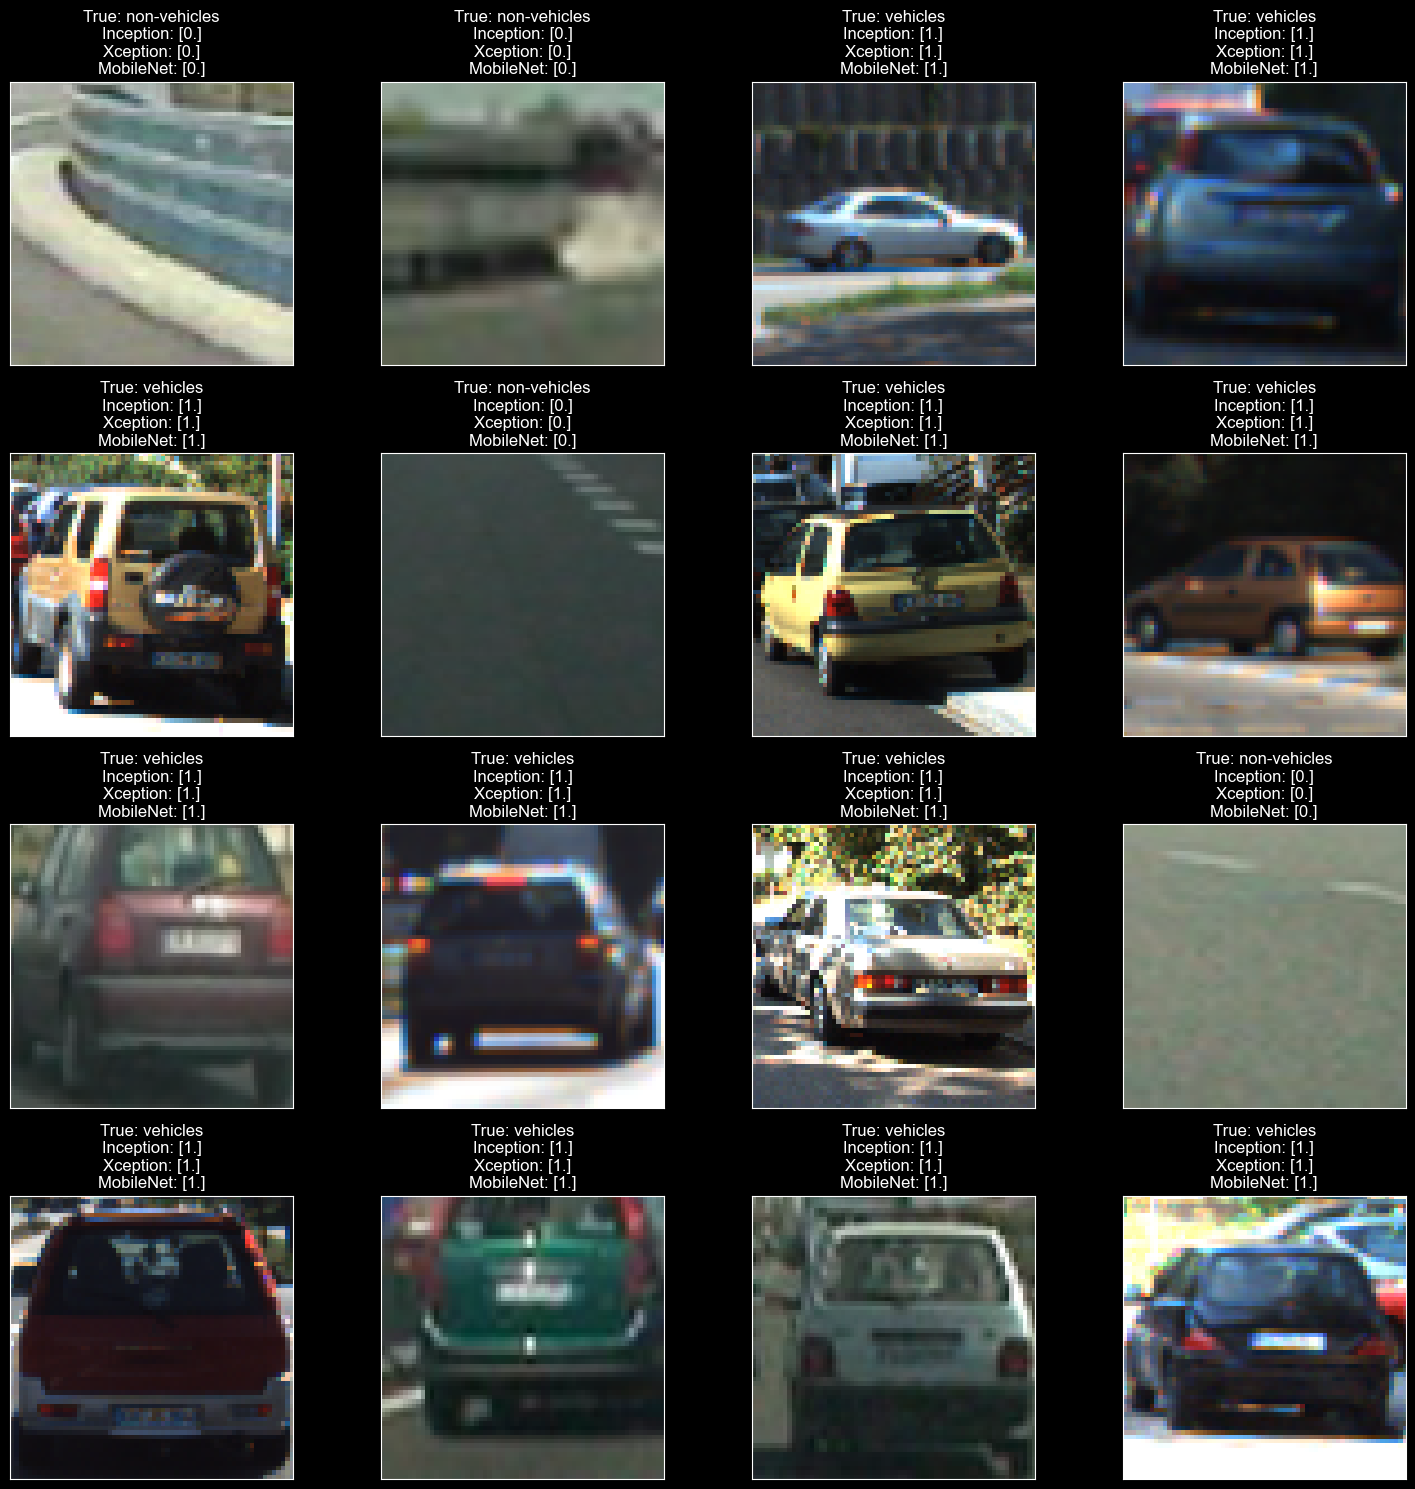

In [49]:
plt.style.use("dark_background")


fig, axes = plt.subplots(nrows = 4,
                         ncols = 4,
                         figsize = (15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testset_df["File"].iloc[i]))
    ax.set_title(f"True: {testset_df.Label.iloc[i]}\nInception: {y_pred_inc[i]}\nXception: {y_pred_xcep[i]}\nMobileNet: {y_pred_mn[i]}")
plt.tight_layout()
plt.show()